In [1]:
import kagglehub
import os
df_path = kagglehub.dataset_download('emmarex/plantdisease')
print(os.listdir(df_path))

100%|██████████| 658M/658M [00:13<00:00, 49.8MB/s]

Extracting files...


Data source import complete.
['PlantVillage', 'plantvillage']


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout, BatchNormalization

## Load Data

In [3]:
fpath = os.path.join(df_path, 'PlantVillage')
random_seed = 111

categories = os.listdir(fpath)

In [4]:
categories.remove("Pepper__bell___Bacterial_spot")
categories.remove("Potato___healthy")

In [5]:
print("All the class labels:- ",categories,"\n\nNo. of categories = ", len(categories))

All the class labels:-  ['Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Septoria_leaf_spot', 'Potato___Early_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Late_blight', 'Tomato__Target_Spot', 'Tomato_Leaf_Mold', 'Pepper__bell___healthy', 'Potato___Late_blight', 'Tomato_Bacterial_spot', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy', 'Tomato_Early_blight'] 

No. of categories =  13



# **Data Exploring**



In [6]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category)[:300]:
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
                img = cv2.imread(fpath+"/"+category+"/"+image_name)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                img_array = Image.fromarray(img, 'RGB')

                resized_img = img_array.resize((227, 227))

                img_lst.append(np.array(resized_img))

                labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  3900 
No. of labels loaded =  3900
<class 'list'> <class 'list'>


In [7]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (3900, 227, 227, 3) 
Labels shape =  (3900,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## The images in the dataset

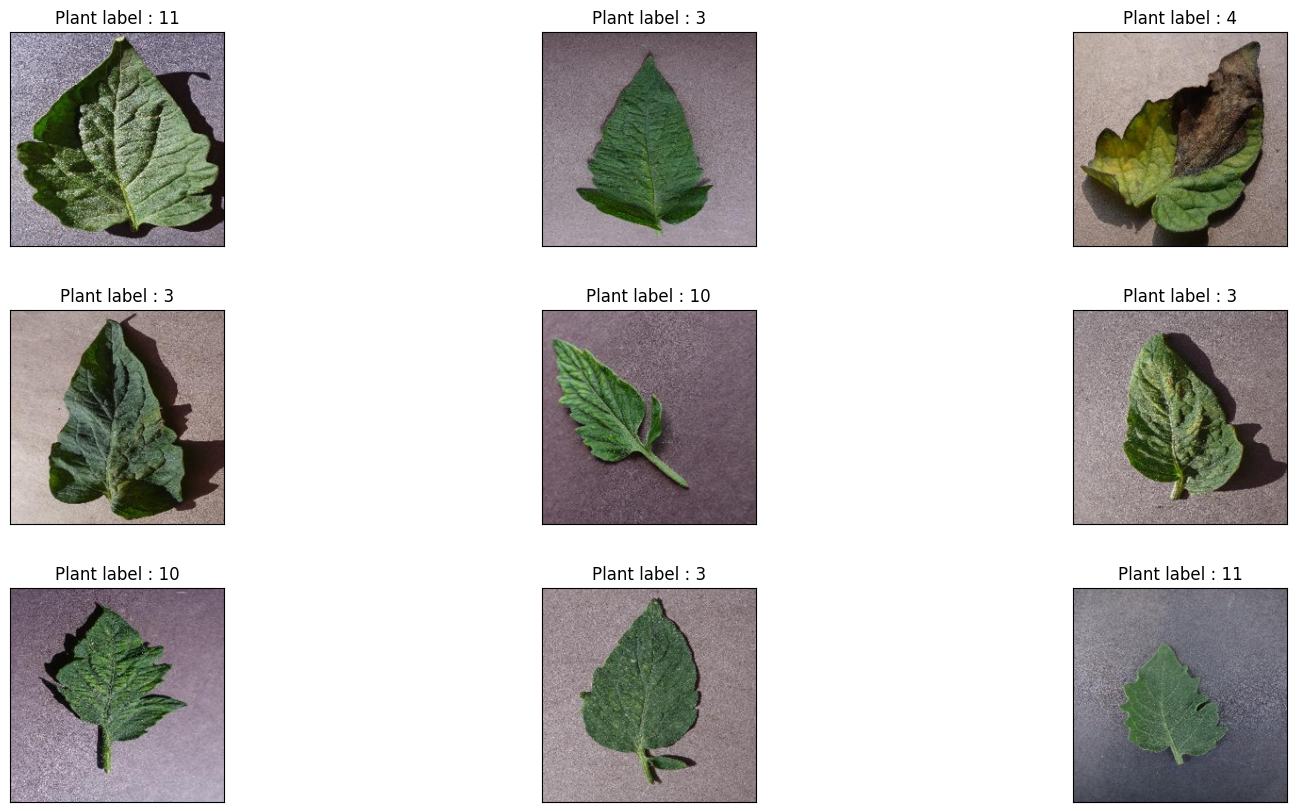

In [8]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0
    for i in range(9):
        n += 1
        r = np.random.randint(0 , images.shape[0] , 1)

        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])

        plt.title('Plant label : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])

    plt.show()

display_rand_images(images, labels)

# Shuffling the data for training of CNN

In [9]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 3897 3898 3899]

'n' values after shuffling =  [1580 1778 2508 ...  724 2004 2924]


In [10]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (3900, 227, 227, 3) 
Labels shape after shuffling =  (3900,)


## Normalizing the loaded Data

In [11]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (3900, 227, 227, 3)


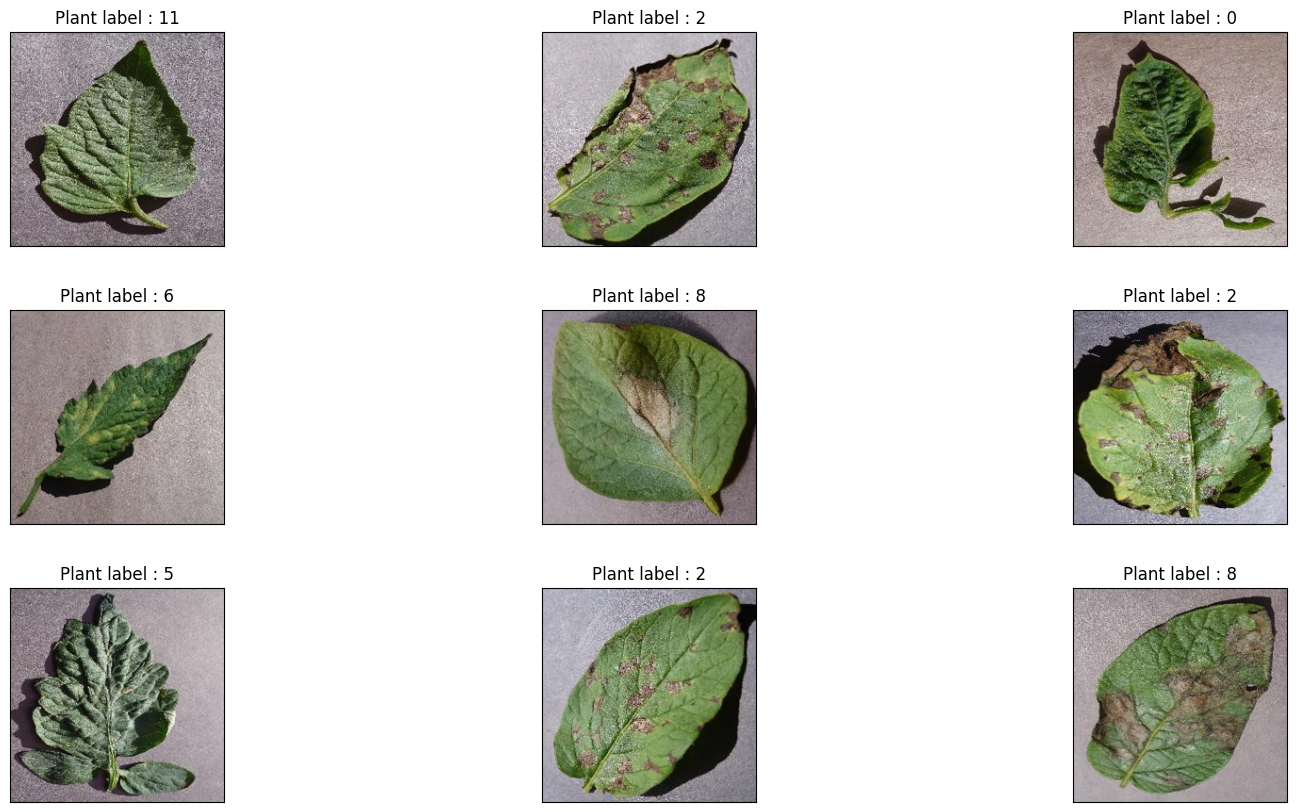

In [12]:
display_rand_images(images, labels)

# Spliting the dataset for training and testing

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (3120, 227, 227, 3)
y_train shape =  (3120,)

x_test shape =  (780, 227, 227, 3)
y_test shape =  (780,)


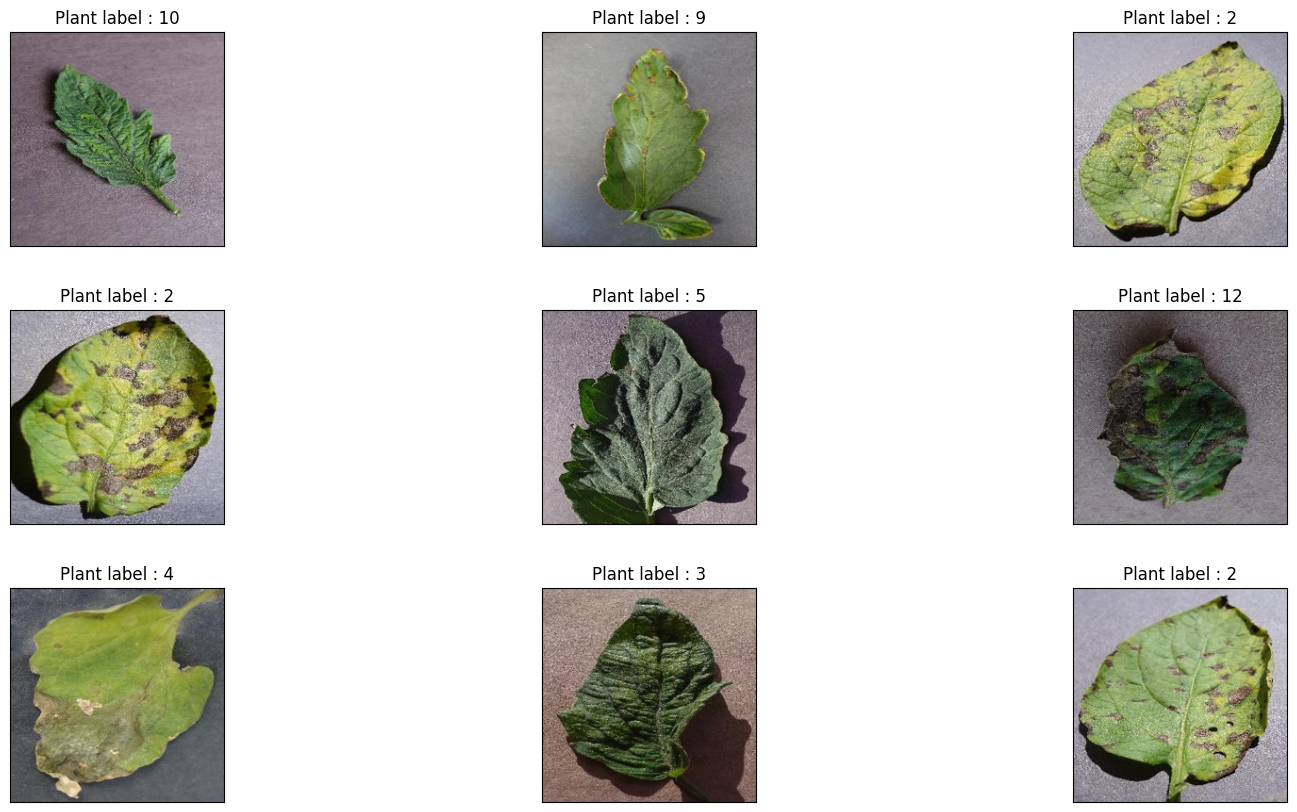

In [14]:
display_rand_images(x_train, y_train)

**CNN model**

In [15]:
model=Sequential()

#1 conv layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(227,227,3)))

#1 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#2 conv layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))

#2 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())

#3 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#4 conv layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#5 conv layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

#3 max pool layer
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

model.add(BatchNormalization())


model.add(Flatten())

#1 dense layer
model.add(Dense(4096,input_shape=(227,227,3),activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#2 dense layer
model.add(Dense(4096,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#3 dense layer
model.add(Dense(1000,activation="relu"))

model.add(Dropout(0.4))

model.add(BatchNormalization())

#output layer
model.add(Dense(20,activation="softmax"))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 27, 27, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 23, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 9, 9, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 7, 7, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 5, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │       4,198,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 4096)                │          16,384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │       4,097,0

 Total params: 28,883,132 (110.18 MB)

 Trainable params: 28,863,532 (110.11 MB)

 Non-trainable params: 19,600 (76.56 KB)

### Compiling the CNN model

In [16]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Using the training data to train the model

In [17]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.2372 - loss: 3.0116
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 379s 3s/step - accuracy: 0.4051 - loss: 1.9677
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.5384 - loss: 1.5091
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.6160 - loss: 1.1645
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.6406 - loss: 1.0901
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 383s 3s/step - accuracy: 0.7192 - loss: 0.8356
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 381s 3s/step - accuracy: 0.7320 - loss: 0.8097
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 336s 3s/step - accuracy: 0.7303 - loss: 0.7686
Epoch 9/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 380s 3s/step - accuracy: 0.7728 - loss: 0.6574
Epoch 10/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.8073 - loss: 0.5644


### Using the train model to predict the values

In [18]:
pred = model.predict(x_test)

pred.shape

25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 785ms/step


(780, 20)

**Images of Actual vs Predicted values**

Plant label : 2
Plant label : 7
Plant label : 2
Plant label : 7
Plant label : 5
Plant label : 5
Plant label : 3
Plant label : 2
Plant label : 12


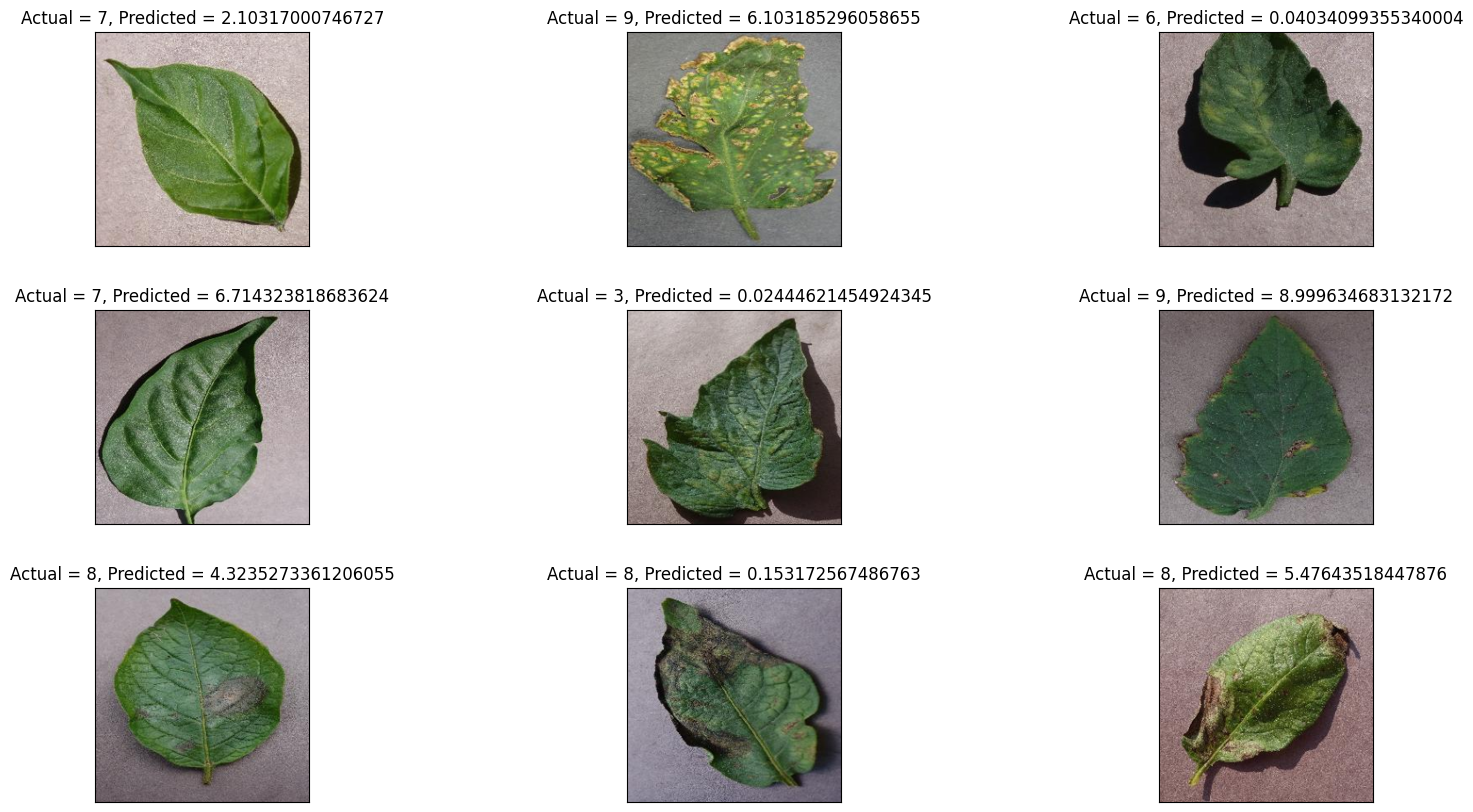

In [19]:
plt.figure(1 , figsize = (19 , 10))
n = 0

for i in range(9):
    n += 1
    r = np.random.randint( 0, x_test.shape[0], 1)

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)

    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])
    print('Plant label : {}'.format(labels[r[0]]))


plt.show()

**Saving the model**

25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step
Image 1:
  Actual Label: 5
  Predicted Label: 3
  Disease Status: Diseased: 3
  Confidence: 94.82%
Image 2:
  Actual Label: 5
  Predicted Label: 7
  Disease Status: Diseased: 7
  Confidence: 85.74%
Image 3:
  Actual Label: 5
  Predicted Label: 5
  Disease Status: Diseased: 5
  Confidence: 53.61%
Image 4:
  Actual Label: 5
  Predicted Label: 7
  Disease Status: Diseased: 7
  Confidence: 98.23%
Image 5:
  Actual Label: 5
  Predicted Label: 5
  Disease Status: Diseased: 5
  Confidence: 97.88%
Image 6:
  Actual Label: 5
  Predicted Label: 5
  Disease Status: Healthy
  Confidence: 99.92%
Image 7:
  Actual Label: 5
  Predicted Label: 10
  Disease Status: Diseased: 10
  Confidence: 99.90%
Image 8:
  Actual Label: 5
  Predicted Label: 5
  Disease Status: Healthy
  Confidence: 100.00%
Image 9:
  Actual Label: 5
  Predicted Label: 12
  Disease Status: Diseased: 12
  Confidence: 95.49%


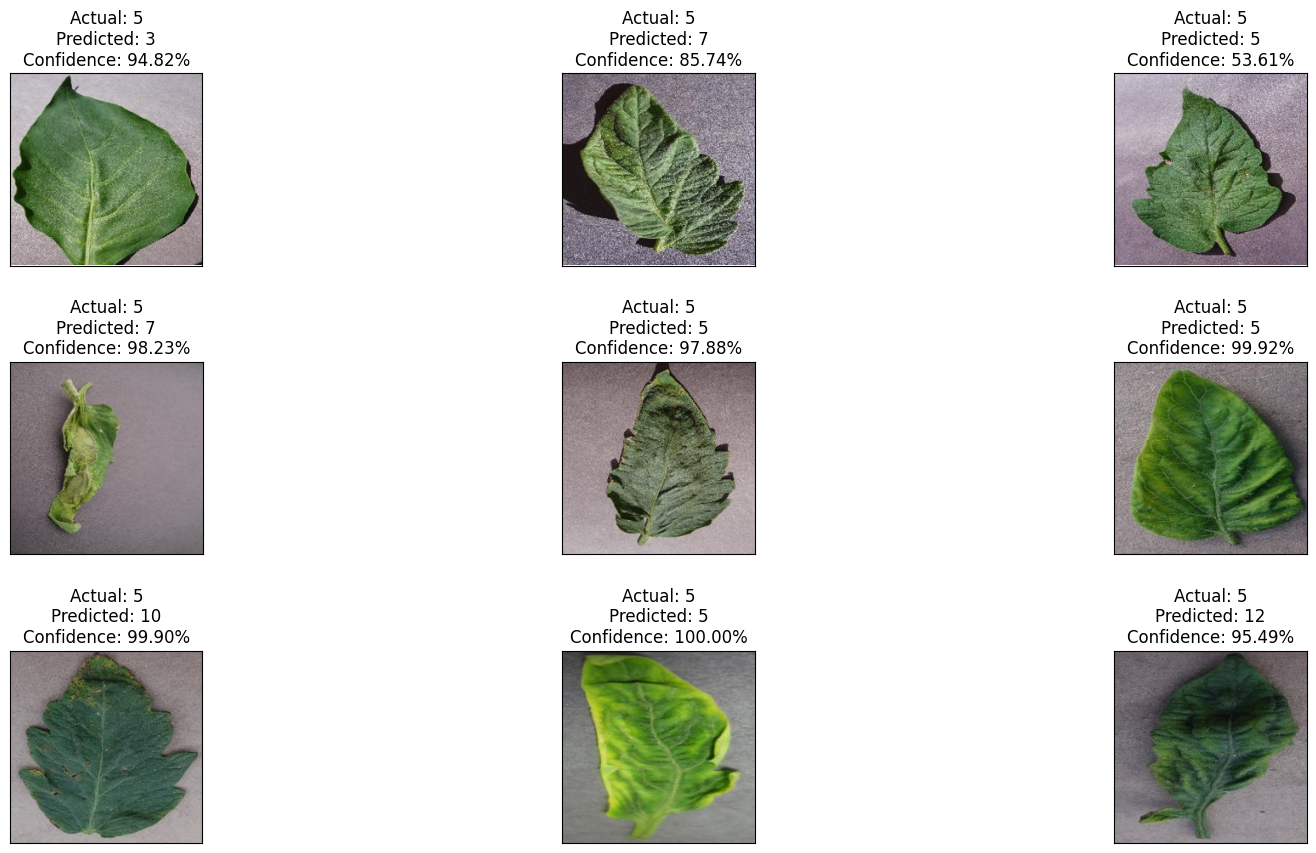

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following:
# model: Your trained deep learning model (e.g., model for plant disease classification)
# x_test: The test dataset images (shape: [num_samples, image_height, image_width, num_channels])
# y_test: The test dataset labels (one-hot encoded)
# labels: List of disease labels (e.g., ["Healthy", "Tomato__Early_blight", "Tomato__Late_blight", ...])

# Generate predictions (pred: probabilities for each class)
pred = model.predict(x_test)

# Create a figure for displaying images
plt.figure(1, figsize=(19, 10))
n = 0

# Loop to display 9 random test images
for i in range(9):
    n += 1
    r = np.random.randint(0, x_test.shape[0], 1)  # Select a random test image

    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)

    # Display the image
    plt.imshow(x_test[r[0]])

    # Get the actual and predicted class
    actual_class = np.argmax(y_test[r[0]])  # Get the actual class index (from y_test)
    predicted_class = np.argmax(pred[r[0]])  # Get the predicted class index (from model prediction)

    # Retrieve disease status from the labels
    actual_label = labels[actual_class]  # Actual disease label
    predicted_label = labels[predicted_class]  # Predicted disease label

    # Calculate the prediction confidence
    confidence = pred[r[0]][predicted_class] * 100  # Confidence for predicted class

    # Determine disease status for display
    disease_status = f"Diseased: {predicted_label}" if predicted_class != 0 else "Healthy"

    # Display the image with title showing actual vs predicted class and confidence
    plt.title(
        f'Actual: {actual_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%'
    )

    # Remove axis ticks for clarity
    plt.xticks([]), plt.yticks([])

    # Print detailed information for each displayed image
    print(f"Image {n}:")
    print(f"  Actual Label: {actual_label}")
    print(f"  Predicted Label: {predicted_label}")
    print(f"  Disease Status: {disease_status}")
    print(f"  Confidence: {confidence:.2f}%")

# Show the plot with the displayed images and results
plt.show()
